Домашнее задание
Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Повторить п.2, но используя уже не медиану, а max
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
import re
import numpy as np
import nltk
import itertools
# nltk.download()
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2
#!pip install python-Levenshtein

# Исходные данные

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
# Обходимся тем списком, что есть)
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\effg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\effg\AppData\Local\Temp\ipykernel_13816\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 36.3 s
Wall time: 36.5 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 4min 53s
Wall time: 5min 3s


А теперь в 3 строчки обучим нашу модель

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [10]:
common_dictionary[20]

'европа'

In [11]:
len(common_dictionary)

141244

In [12]:
len(common_corpus)

27000

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)
temp_file = datapath("..\model.lda")
lda.save(temp_file)

In [14]:
# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
%%time
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']
CPU times: total: 0 ns
Wall time: 2 ms


[(3, 0.041603357),
 (15, 0.59803605),
 (16, 0.14271522),
 (19, 0.14824802),
 (23, 0.051497824)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: граница турецкий район товар письмо франция турция
topic_1: экипаж космос дональд фильм следствие законодательство школа
topic_2: мозг активность доклад год египет который житель
topic_3: год nn это россия который наука первый
topic_4: исследование обнаружить журнал который проверка продукция это
topic_5: тепло пережить египетский болгария сербия лечить югославия
topic_6: это мочь россия который президент год всё
topic_7: статья эксперимент солнце конкурс форум японский супруг
topic_8: население снижение взрыв это северный результат nn
topic_9: сша военный поверхность высота армия боевой космонавт
topic_10: пациент препарат лечение мальчик сбить врач клиника
topic_11: гражданин фронт народный миллиард ребёнок курение артист
topic_12: год млрд рубль рост тыс млн фонд
topic_13: газ ракета район двигатель станция авария испытание
topic_14: пенсия мышь памятник армения макаров развивающийся актуальный
topic_15: исследование женщина ребёнок человек это мужчина возраст
topic_16: ком

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

CPU times: total: 57.1 s
Wall time: 53 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.143434,0.0,0.000000,...,0.000000,0.000000,0.000000,0.025091,0.050629,0.0,0.0,0.0,0.557900,0.215746
1,4896,0.0,0.0,0.0,0.133038,0.0,0.0,0.000000,0.0,0.545102,...,0.000000,0.000000,0.000000,0.000000,0.299832,0.0,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.0,0.0,0.041600,0.0,0.0,0.000000,0.0,0.000000,...,0.598039,0.142725,0.000000,0.000000,0.148240,0.0,0.0,0.0,0.051497,0.000000
3,4898,0.0,0.0,0.0,0.329543,0.0,0.0,0.129378,0.0,0.000000,...,0.353242,0.065919,0.032976,0.000000,0.079724,0.0,0.0,0.0,0.000000,0.000000
4,4899,0.0,0.0,0.0,0.174604,0.0,0.0,0.320677,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.479792,0.0,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.13299811, 0.        , 0.        , 0.28090516, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.22019123, 0.01510986, 0.06740847, 0.15217733, 0.        ,
       0.12028623, 0.        , 0.        , 0.        , 0.        ])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.01342896, 0.01110938, 0.0027961 , 0.03864355, 0.01701844,
       0.        , 0.19669434, 0.00486176, 0.03940504, 0.0461354 ,
       0.        , 0.00710701, 0.01756226, 0.00468907, 0.        ,
       0.05153306, 0.        , 0.00393268, 0.18534543, 0.        ,
       0.24902135, 0.        , 0.        , 0.00480872, 0.0973674 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [24]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [25]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.022166,0.012698,0.013630,0.200218,0.033795,0.007591,0.037908,0.000000,0.015833,...,0.036699,0.026174,0.015476,0.253865,0.000000,0.161152,0.000000,0.000000,0.012093,0.078982
1,u108690,0.029110,0.004814,0.012542,0.059199,0.011005,0.000000,0.237846,0.005741,0.039239,...,0.055027,0.000000,0.073315,0.151317,0.009978,0.133023,0.011013,0.000000,0.002286,0.108155
2,u108339,0.006095,0.000000,0.089752,0.102865,0.012128,0.000000,0.116151,0.002254,0.059050,...,0.006836,0.004743,0.067709,0.160662,0.000000,0.229836,0.000000,0.002482,0.020338,0.020182


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.022166,0.012698,0.013630,0.200218,0.033795,0.007591,0.037908,0.000000,0.015833,...,0.026174,0.015476,0.253865,0.000000,0.161152,0.000000,0.000000,0.012093,0.078982,0
1,u108690,0.029110,0.004814,0.012542,0.059199,0.011005,0.000000,0.237846,0.005741,0.039239,...,0.000000,0.073315,0.151317,0.009978,0.133023,0.011013,0.000000,0.002286,0.108155,1
2,u108339,0.006095,0.000000,0.089752,0.102865,0.012128,0.000000,0.116151,0.002254,0.059050,...,0.004743,0.067709,0.160662,0.000000,0.229836,0.000000,0.002482,0.020338,0.020182,1


In [29]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [30]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.27515456, 0.06963034, 0.43195419, 0.20978993, 0.01895652,
       0.05256658, 0.07887762, 0.03404215, 0.03676924, 0.16247275])

### Рассчитаем Precision, Recall, F_score

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.585690, F-Score=nan, Precision=0.000, Recall=0.000


C:\Users\effg\AppData\Local\Temp\ipykernel_13816\3063505166.py:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1753    2]
 [ 245    0]]


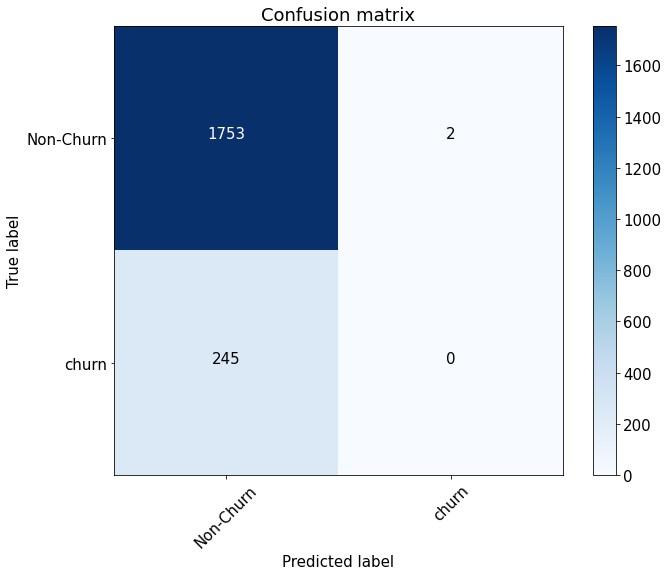

In [34]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [35]:
roc_auc_score(y_test, preds)

0.9144322344322344

In [36]:
roc_auc_mean, precision_mean, recall_mean = roc_auc_score(y_test, preds), precision, recall
f_score_mean = 2 * (precision * recall) / (precision + recall)

C:\Users\effg\AppData\Local\Temp\ipykernel_13816\3575247079.py:2: RuntimeWarning: invalid value encountered in true_divide
  f_score_mean = 2 * (precision * recall) / (precision + recall)


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

***
***
***

# 1. Модифицировать код функции get_user_embedding
* Модифицировать таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана.  
* Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их:  
roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [37]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
    user_vector = np.median(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [38]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.222102,0.009187,0.0,0.000000,0.0,0.000000,...,0.000000,0.007555,0.000000,0.176258,0.0,0.191924,0.0,0.0,0.0,0.000000
1,u108690,0.015802,0.0,0.000000,0.067632,0.005174,0.0,0.211153,0.0,0.009034,...,0.038767,0.000000,0.070770,0.172835,0.0,0.059648,0.0,0.0,0.0,0.102519
2,u108339,0.000000,0.0,0.091328,0.081730,0.000000,0.0,0.092478,0.0,0.028892,...,0.000000,0.000000,0.058043,0.156953,0.0,0.259051,0.0,0.0,0.0,0.008999


Датасет готов,  обучаем модель. Загружаем разметку

In [39]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [40]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.222102,0.009187,0.0,0.000000,0.0,0.000000,...,0.007555,0.000000,0.176258,0.0,0.191924,0.0,0.0,0.0,0.000000,0
1,u108690,0.015802,0.0,0.000000,0.067632,0.005174,0.0,0.211153,0.0,0.009034,...,0.000000,0.070770,0.172835,0.0,0.059648,0.0,0.0,0.0,0.102519,1
2,u108339,0.000000,0.0,0.091328,0.081730,0.000000,0.0,0.092478,0.0,0.028892,...,0.000000,0.058043,0.156953,0.0,0.259051,0.0,0.0,0.0,0.008999,1


In [41]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [42]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [43]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18137073, 0.15680033, 0.4003495 , 0.42016525, 0.02629139,
       0.01115596, 0.10632795, 0.04731069, 0.03896038, 0.16096174])

### Рассчитаем Precision, Recall, F_score

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.250594, F-Score=0.645, Precision=0.577, Recall=0.731


In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1624  131]
 [  67  178]]


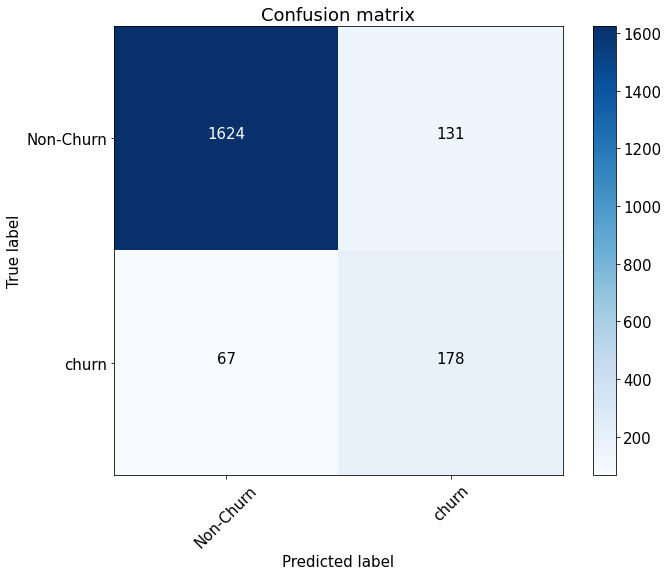

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
roc_auc_score(y_test, preds)

0.9368079539508112

In [48]:
roc_auc_median, precision_median, recall_median = roc_auc_score(y_test, preds), precision, recall
f_score_median = 2 * (precision * recall) / (precision + recall)

# 2. Повторить п.1, но используя уже не медиану, а max

In [49]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [50]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.132998,0.076188,0.081778,0.476197,0.132895,0.045549,0.188815,0.000000,0.094997,...,0.220191,0.117308,0.067408,0.673159,0.000000,0.299758,0.000000,0.000000,0.072560,0.420468
1,u108690,0.098249,0.028883,0.052414,0.099377,0.036403,0.000000,0.414645,0.018329,0.168845,...,0.172868,0.000000,0.138227,0.245210,0.059867,0.452938,0.066077,0.000000,0.013716,0.241922
2,u108339,0.036569,0.000000,0.195848,0.203303,0.055341,0.000000,0.351289,0.013524,0.189836,...,0.024075,0.028457,0.164964,0.275179,0.000000,0.348646,0.000000,0.014891,0.094437,0.064587


Датасет готов. Загружаем разметку.

In [51]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [52]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.132998,0.076188,0.081778,0.476197,0.132895,0.045549,0.188815,0.000000,0.094997,...,0.117308,0.067408,0.673159,0.000000,0.299758,0.000000,0.000000,0.072560,0.420468,0
1,u108690,0.098249,0.028883,0.052414,0.099377,0.036403,0.000000,0.414645,0.018329,0.168845,...,0.000000,0.138227,0.245210,0.059867,0.452938,0.066077,0.000000,0.013716,0.241922,1
2,u108339,0.036569,0.000000,0.195848,0.203303,0.055341,0.000000,0.351289,0.013524,0.189836,...,0.028457,0.164964,0.275179,0.000000,0.348646,0.000000,0.014891,0.094437,0.064587,1


In [53]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [54]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.42362419e-01, 1.85426431e-03, 7.44077069e-01, 1.28293802e-01,
       4.65375679e-02, 6.04648860e-04, 1.84930721e-03, 2.36447444e-02,
       5.17230111e-02, 4.84753966e-02])

### Рассчитаем Precision, Recall, F_score

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.325286, F-Score=0.764, Precision=0.711, Recall=0.824


In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1673   82]
 [  44  201]]


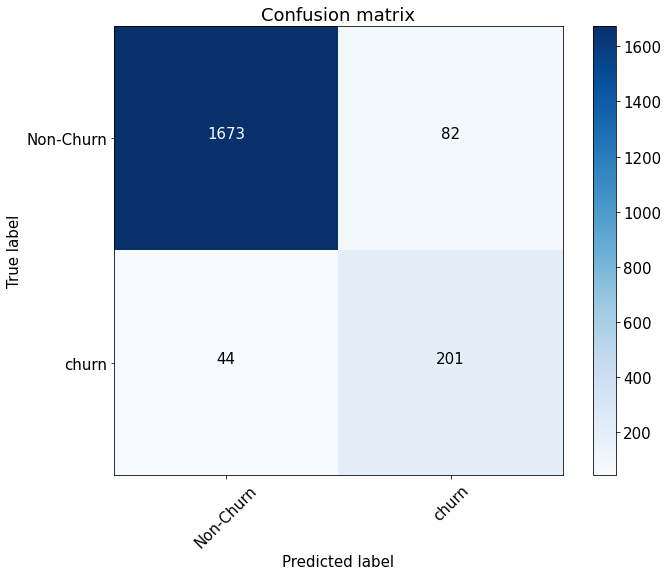

In [58]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
roc_auc_score(y_test, preds)

0.9715053200767487

In [60]:
roc_auc_max, precision_max, recall_max = roc_auc_score(y_test, preds), precision, recall
f_score_max = 2 * (precision * recall) / (precision + recall)

# 3. Сформировать на выходе единую сравнивающую таблицу качества моделей
Сравнить 3 разных метода получения эмбедингов пользователей:  
mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [64]:
def df_highlight_max(s):
    '''
    highlight the maximum
    '''
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

def df_bold_max(s):
    '''
    bold the maximum
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

metrics = ['roc_auc',
           'precision',
           'recall',
           'f_score']
metrics_types = ['mean',
                 'median',
                 'max']

models_acccuracy = pd.DataFrame(columns=metrics_types)
for col in metrics_types:
    for row in metrics:
        models_acccuracy.loc[row, col] = np.mean(eval(f'{row}_{col}'))
print('Сравнение качества получившихся данных\nпо столбцам -- метод,\nпо строкам -- метрика,\n\
цветом -- наилучшее значение\n')
models_acccuracy.style.apply(df_highlight_max, axis=1).apply(df_bold_max, axis=1)

Сравнение качества получившихся данных
по столбцам -- метод,
по строкам -- метрика,
цветом -- наилучшее значение



,mean,median,max
roc_auc,0.914432,0.936808,0.971505
precision,0.400089,0.481617,0.604577
recall,0.766520,0.753528,0.785881
f_score,nan,0.509251,0.591289


# 4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Метод с максимальным значением -  эффективнее. 